## Import libraries

In [1]:
import pandas as pd
import numpy as np
import tweepy
import us
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from adjustText import adjust_text
from datetime import timedelta

## Set library parameters

In [2]:
# Pandas display options
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.max_colwidth', -1)

# Pandas + matplotlib
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

# Pyplot options
plt.rcParams.update({'font.size': 16, 'font.sans-serif': 'Arial'})

## Import data

### Tweets

Data downloaded from the `tweets` sheet of https://corona-tweets.datasettecloud.com (after filtering for `created_at` > `2019-12-01`)

In [3]:
tweets_sheet = '../data/source/tweets-20200406-1732PST.csv'
df_tweets = pd.read_csv(tweets_sheet, dtype={'user': object})
df_tweets.head()

/Users/ihwang/.local/share/virtualenvs/covid19-tweets-jKmwAzGh/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3063: DtypeWarning: Columns (0,29) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,id,user,user_label,created_at,full_text,retweeted_status,retweeted_status_label,quoted_status,quoted_status_label,place,place_label,source,source_label,truncated,display_text_range,in_reply_to_status_id,in_reply_to_user_id,in_reply_to_screen_name,geo,coordinates,contributors,is_quote_status,retweet_count,favorite_count,favorited,retweeted,lang,possibly_sensitive,scopes,withheld_in_countries
0,1247314394427482113,236511574,Senator Gary Peters,2020-04-07T00:05:00+00:00,"The bipartisan CARES Act was an important first step, but there is still more work to support Michigan families. \n \n@SenStabenow & I Introduced a bill to make families w/ older children & adult dependents eligible for COVID-19 relief payments. https://twitter.com/SenGaryPeters/status/1247314394427482113/video/1",NaN,NaN,NaN,NaN,NaN,NaN,605db6f136ed878a4ef11d44dbc6b056a17505f3,Twitter Media Studio,0.0,"[0, 251]",NaN,NaN,NaN,NaN,NaN,NaN,0.0,3.0,4.0,0.0,0.0,en,0.0,NaN,NaN
1,1247314137266470912,24195214,Jan Schakowsky,2020-04-07T00:03:58+00:00,RT @IRSnews: Thinking about taxes? So are phone scammers! Criminals often pose as #IRS agents and try to steal your money and information.…,1.247313e+18,1.247313e+18,NaN,NaN,NaN,NaN,1f89d6a41b1505a3071169f8d0d028ba9ad6f952,Twitter Web App,0.0,"[0, 139]",NaN,NaN,NaN,NaN,NaN,NaN,0.0,2.0,0.0,0.0,0.0,en,NaN,NaN,NaN
2,1247313969817288712,1075517806551154689,Rep. Veronica Escobar,2020-04-07T00:03:19+00:00,RT @IRSnews: Thinking about taxes? So are phone scammers! Criminals often pose as #IRS agents and try to steal your money and information.…,1.247313e+18,1.247313e+18,NaN,NaN,NaN,NaN,9335de48b3673c3f69433a34861c115d1d382be3,TweetDeck,0.0,"[0, 139]",NaN,NaN,NaN,NaN,NaN,NaN,0.0,4.0,0.0,0.0,0.0,en,NaN,NaN,NaN
3,1247313933200953344,168502762,Rep. Eddie Bernice Johnson,2020-04-07T00:03:10+00:00,"Today, I along w/53 Members sent a letter to the White House Coronavirus Taskforce to ensure medication access for #lupus and rheumatoid arthritis patients during #COVID19. Thanks @RepMcKinley,@USRepKeating, @RepPeteKing, & @RepDebDingell for partnering on this effort! https://twitter.com/RepEBJ/status/1247313933200953344/photo/1",NaN,NaN,NaN,NaN,NaN,NaN,9335de48b3673c3f69433a34861c115d1d382be3,TweetDeck,0.0,"[0, 274]",NaN,NaN,NaN,NaN,NaN,NaN,0.0,1.0,3.0,0.0,0.0,en,0.0,NaN,NaN
4,1247313729664008197,24195214,Jan Schakowsky,2020-04-07T00:02:21+00:00,"RT @SenatorDurbin: Glad to see more than 450,000 Illinois households will receive increased SNAP benefits thanks to recent federal legislat…",1.247313e+18,1.247313e+18,NaN,NaN,NaN,NaN,1f89d6a41b1505a3071169f8d0d028ba9ad6f952,Twitter Web App,0.0,"[0, 140]",NaN,NaN,NaN,NaN,NaN,NaN,1.0,12.0,0.0,0.0,0.0,en,NaN,NaN,NaN


### The COVID Tracking Project

Get historical state cases data from The COVID Tracking Project (https://covidtracking.com/api/)

In [4]:
df_states_cases = pd.read_json('https://covidtracking.com/api/states/daily')
df_states_cases['dateChecked'] = pd.to_datetime(df_states_cases['dateChecked'])
df_states_cases['date'] = pd.to_datetime(df_states_cases['date'], format='%Y%m%d')
# df_states_cases.head()

### Local government Twitter Handles

Specify variables to download specific sheets from the `Official_twitter_handles` Google Sheet
* Google Sheet: https://docs.google.com/spreadsheets/d/13wRn7ZswD2p180OQY7JiJgv-CHug36CiQqFkhpzQYwY
* GUIDs refer to the IDs of individual sheeets within the document

In [5]:
sheet_key = '13wRn7ZswD2p180OQY7JiJgv-CHug36CiQqFkhpzQYwY'
guid_dict = {
    'Healthcare': 64630233,
    'Governers': 470577166,
    'Congress': 354414704
}

Import Google Sheet

In [6]:
state_dfs_list = []
for guid_key, guid in guid_dict.items():
    handles_sheet = 'https://docs.google.com/spreadsheets/d/' + sheet_key + \
                    '/export?format=csv&gid=%s' %guid
    state_dfs_list.append(pd.read_csv(handles_sheet))
df_hc_handles, df_gov_handles, df_congress_handles = state_dfs_list

### Shelter-in-place orders

Specify variables to download specific sheets from the `shelter-in-place` Google Sheet
* Google Sheet: https://docs.google.com/spreadsheets/d/1iOChy4gxV3RUz2uHYRHL5OwSbyIV8p9Jo1tTR-R1-Hw
* GUIDs refer to the IDs of individual sheeets within the document

In [7]:
sheet_key = '1iOChy4gxV3RUz2uHYRHL5OwSbyIV8p9Jo1tTR-R1-Hw'
guid_dict = {
    'States': 0,
    'Cities': 1430032085,
    'Counties': 1083934346
}
guid = guid_dict['States']

Import Google Sheet

In [8]:
handles_sheet = 'https://docs.google.com/spreadsheets/d/' + sheet_key + '/export?format=csv&gid=%s' %guid
df_sip = pd.read_csv(handles_sheet)
df_sip['Date effective'] = pd.to_datetime(df_sip['Date effective'])
# df_sip.sort_values('State')

### Twitter API

Read in Twitter credentials from .env file

In [9]:
twitter_creds = '../.env'

with open(twitter_creds) as f:
    for line in f:
        line_contents = line.strip().split('=')
        if line_contents[0] == 'CONSUMER_KEY':
            consumer_key = line_contents[1]
        elif line_contents[0] == 'CONSUMER_SECRET_KEY':
            consumer_secret = line_contents[1]
        elif line_contents[0] == 'ACCESS_TOKEN':
            access_token = line_contents[1]
        elif line_contents[0] == 'ACCESS_TOKEN_SECRET':
            access_token_secret = line_contents[1]
        else:
            pass

Access Twitter API

In [10]:
auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_token_secret)
api = tweepy.API(auth)

## Declare global variables

* Strings related to COVID-19 include: `coronavirus`, `covid` and `ncov`, since some of the most popular hashtags related to the pandemic have been `#ncov2019`, `coronavirus` and `covid` (according to a quick spot-check). The keywords `virus` and `cdc` were too general---some health departments were tweeting about flu and other general health recommendations from the CDC in December 2019.
* CDC and WHO are two large healthcare organizations for which I created a Twitter ID dictionary

In [11]:
covid_strings = 'coronavirus|covid|ncov'
hc_org_dict = {
    'cdc' : '146569971',
    'who' : '14499829'
}

In [12]:
state = 'GA'
state_name = us.states.lookup(state).name
hc_dept = df_hc_handles[df_hc_handles['Abbreviation'] == state]['State Health Department'].iloc[0]
hc_handle = df_hc_handles[df_hc_handles['Abbreviation'] == state]['Twitter Handle'].iloc[0]
gov = df_gov_handles[df_gov_handles['Abbreviation'] == state]['Governor'].iloc[0]
gov_handle = df_gov_handles[df_gov_handles['Abbreviation'] == state]['Handle'].iloc[0]
sip_date = df_sip[df_sip['State'] == state_name]['Date effective'].iloc[0]

## Process raw data

Get Twitter user IDs from handles

In [13]:
hc_user_id = str(api.get_user(hc_handle).id)
gov_user_id = str(api.get_user(gov_handle).id)

Create `df_hc_tweets` and `df_gov_tweets` dataframes and do some basic cleaning up on them

In [14]:
# Join df_tweets and df_hc_handles/df_gov_handles to get dataframes Tweets
df_hc_tweets = df_tweets[df_tweets['user'] == hc_user_id].copy()
df_gov_tweets = df_tweets[df_tweets['user'] == gov_user_id].copy()

# Transform created_at column from Timestamp to DateTime object
df_hc_tweets['created_at'] = pd.to_datetime(df_hc_tweets['created_at'])
df_gov_tweets['created_at'] = pd.to_datetime(df_gov_tweets['created_at'])

for subject, df in [(hc_dept, df_hc_tweets), (gov, df_gov_tweets)]:
    print('Tweets by the %s since December 1, 2019: %s' %(subject, len(df)))

Tweets by the Georgia Department of Public Health since December 1, 2019: 140
Tweets by the Brian Kemp since December 1, 2019: 352


Extract tweets from health departments mentioning COVID-19

In [15]:
# Filter for keywords coronavirus and covid (not case-sensitive)
df_hc_covid_tweets = df_hc_tweets[(df_hc_tweets['full_text'].\
                                  str.contains(covid_strings, regex=True, case=False))]
df_gov_covid_tweets = df_gov_tweets[(df_gov_tweets['full_text'].\
                                  str.contains(covid_strings, regex=True, case=False))]

for subject, df in [(hc_dept, df_hc_covid_tweets), (gov, df_gov_covid_tweets)]:
    print('COVID-19 Tweets by the %s since December 1, 2019: %s' 
          %(subject, len(df)))

COVID-19 Tweets by the Georgia Department of Public Health since December 1, 2019: 92
COVID-19 Tweets by the Brian Kemp since December 1, 2019: 188


State healthcare department Tweets

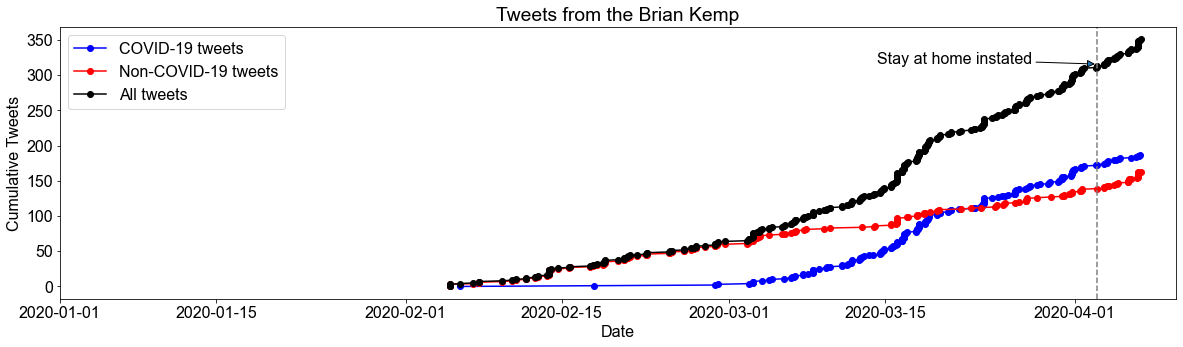

In [30]:
subject = gov
# subject = hc_dept

if subject == gov:
    df_plot = df_gov_covid_tweets
    df_all = df_gov_tweets
else:
    df_plot = df_hc_covid_tweets
    df_all = df_hc_tweets

# Define df
df_plot = df_plot.sort_values('created_at').reset_index()
df_plot2 = df_all[
    ~(df_all['full_text'].str.contains(covid_strings, regex=True, case=False))
]
df_plot2 = df_plot2.sort_values('created_at').reset_index()
df_plot3 = df_all
df_plot3 = df_plot3.sort_values('created_at').reset_index()

# Define figure parameters
fsize=16
fig, axes = plt.subplots(figsize=(20, 5))

axes.plot(df_plot['created_at'], df_plot.index, 'o-', color='blue', label='COVID-19 tweets')
axes.plot(df_plot2['created_at'], df_plot2.index, 'o-', color='red', label='Non-COVID-19 tweets')
axes.plot(df_plot3['created_at'], df_plot3.index, 'o-', color='black', label='All tweets')

if pd.notnull(sip_date):
    sip_order = df_sip[df_sip['State'] == state_name]['Order'].iloc[0]
    axes.axvline(x=mdates.date2num(sip_date), linestyle='--', color='grey')
    axes.annotate(sip_order + ' instated', (mdates.date2num(sip_date), .9*max(df_plot3.index)), xytext=(-220,0), 
                textcoords='offset points', arrowprops=dict(arrowstyle='-|>'))

axes.set_xlim(pd.Timestamp('2020-01-01'))
axes.set_title('Tweets from the %s' %subject)
axes.set_ylabel('Cumulative Tweets')
axes.set_xlabel('Date')
axes.legend(loc='upper left')
plt.show()

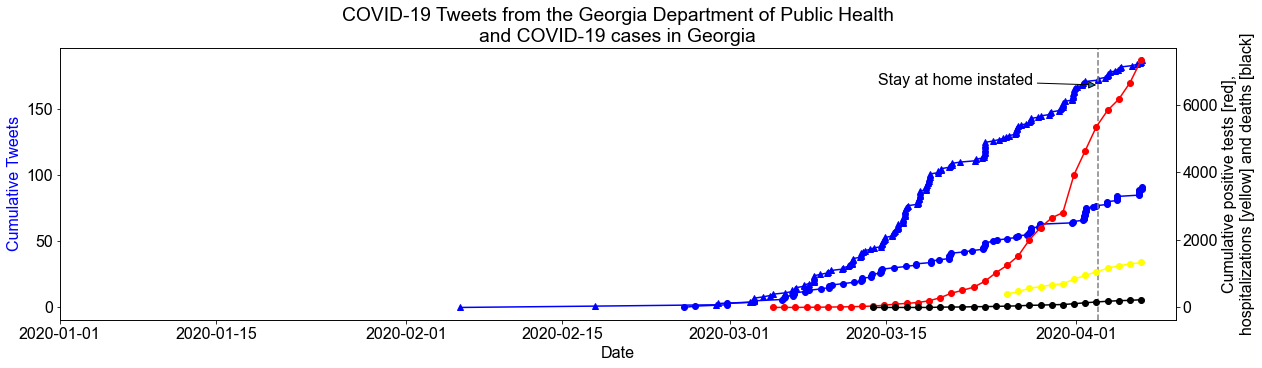

In [24]:
# Define df
df_plot_hc = df_hc_covid_tweets
df_plot_hc = df_plot_hc.sort_values('created_at').reset_index()
df_plot_gov = df_gov_covid_tweets
df_plot_gov = df_plot_gov.sort_values('created_at').reset_index()
df_state = df_states_cases[df_states_cases['state'] == state]

# Define figure parameters
fsize=16
fig, axes = plt.subplots(figsize=(20, 5))
axes2 = axes.twinx()

axes.plot(df_plot_hc['created_at'], df_plot_hc.index, 'o-', color='blue')
axes.plot(df_plot_gov['created_at'], df_plot_gov.index, '^-', color='blue')
axes2.plot(df_state['dateChecked'], df_state['positive'], 'o-', color='red')
axes2.plot(df_state['dateChecked'], df_state['death'], 'o-', color='black')
axes2.plot(df_state['dateChecked'], df_state['hospitalized'], 'o-', color='yellow')

if pd.notnull(sip_date):
    sip_order = df_sip[df_sip['State'] == state_name]['Order'].iloc[0]
    axes.axvline(x=mdates.date2num(sip_date), linestyle='--', color='grey')
    axes.annotate(sip_order + ' instated', 
                  (mdates.date2num(sip_date), .9*max(max(df_plot_hc.index), max(df_plot_gov.index))), 
                  xytext=(-220,0), 
                textcoords='offset points', arrowprops=dict(arrowstyle='-|>'))

axes.set_xlim(pd.Timestamp('2020-01-01'))
axes.set_title('COVID-19 Tweets from the %s\nand COVID-19 cases in %s' %(hc_dept, us.states.lookup(state).name))
axes.set_ylabel('Cumulative Tweets', color='blue')
axes2.set_ylabel('Cumulative positive tests [red],\nhospitalizations [yellow] and deaths [black]')
axes.set_xlabel('Date')
plt.show()

Get a feel for engagement with and by the account:
* Engagement by the account: total number of Tweets that are retweets or quotes
* Engagement with the account: total retweets of this acccount's Tweets

Top accounts this account engaged with?

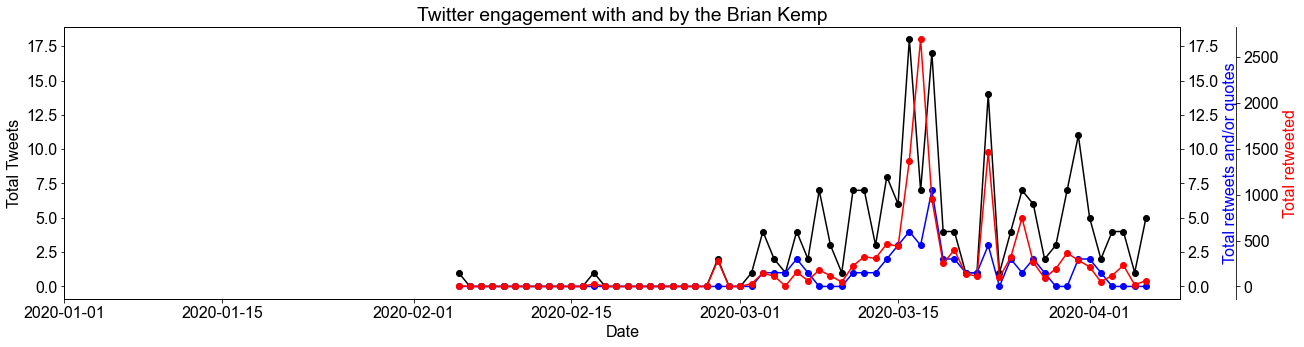

In [32]:
subject = gov
# subject = hc_dept

if subject == gov:
    df_plot = df_gov_covid_tweets
    df_all = df_gov_tweets
else:
    df_plot = df_hc_covid_tweets
    df_all = df_hc_tweets

# Define df
df_total = df_plot[['created_at']].resample('D', on='created_at').count()
df_engaged_with_counts = df_plot[['created_at', 'retweeted_status', 'quoted_status']].resample('D', on='created_at').count()
series_engaged_with = df_engaged_with_counts.drop(columns=['created_at']).sum(axis=1)
df_engaged_by = df_plot[['created_at', 'retweet_count']].resample('D', on='created_at').sum()

# Define figure parameters
fsize=16
fig, axes = plt.subplots(figsize=(20, 5))
axes2 = axes.twinx()
axes3 = axes.twinx()
rspine = axes3.spines['right']
rspine.set_position(('axes', 1.05))

axes.plot(df_total.index, df_total, 'o-', color='black')
axes2.plot(series_engaged_with.index, series_engaged_with, 'o-', color='blue')
axes3.plot(df_engaged_by.index, df_engaged_by['retweet_count'], 'o-', color='red')

axes.set_xlim(pd.Timestamp('2020-01-01'))
axes2.set_ylim(axes.get_ylim())
axes.set_title('Twitter engagement with and by the %s' %subject)
axes.set_ylabel('Total Tweets', color='black')
axes2.set_ylabel('Total retweets and/or quotes', color='blue')
axes3.set_ylabel('Total retweeted', color='red')
axes.set_xlabel('Date')
plt.show()

Let's look at the Tweets more closely

In [19]:
df_hc_tweets.sort_values('created_at')
# df_hc_covid_tweets.sort_values('created_at')

,id,user,user_label,created_at,full_text,retweeted_status,retweeted_status_label,quoted_status,quoted_status_label,place,place_label,source,source_label,truncated,display_text_range,in_reply_to_status_id,in_reply_to_user_id,in_reply_to_screen_name,geo,coordinates,contributors,is_quote_status,retweet_count,favorite_count,favorited,retweeted,lang,possibly_sensitive,scopes,withheld_in_countries
241993,1225077559710404614,325113018,GaDeptPublicHealth,2020-02-05 15:23:45+00:00,"RT @NCHD52: Georgia continues to fight against the outbreak of hepatitis A in our communities. The disease can spread in many ways, but get…",1.225046e+18,1.225046e+18,NaN,NaN,NaN,NaN,ef22bdcbaf9be5b60db28a05006e3f3ebc1fa61d,Hootsuite Inc.,0.0,"[0, 140]",NaN,NaN,NaN,NaN,NaN,NaN,0.0,3.0,0.0,0.0,0.0,en,NaN,NaN,NaN
226921,1226926671443484673,325113018,GaDeptPublicHealth,2020-02-10 17:51:28+00:00,"Valentine’s Day is about celebrating those you love, but if the muscle in your chest pumping oxygenated blood to all your vital organs – the heart – can’t do its job well, show your heart some love first. Learn how: http://bit.ly/2HdpK73 #LiveWellGA https://twitter.com/GaDPH/status/1226926671443484673/photo/1",NaN,NaN,NaN,NaN,NaN,NaN,ef22bdcbaf9be5b60db28a05006e3f3ebc1fa61d,Hootsuite Inc.,0.0,"[0, 251]",NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,1.0,0.0,0.0,en,0.0,NaN,NaN
205343,1229814569129869313,325113018,GaDeptPublicHealth,2020-02-18 17:06:56+00:00,"RT @CDPHga: You should get tested once a year, even if you use condoms regularly. Be sure to ask for a HIV Test at your next check up. Prot…",1.229790e+18,1.229790e+18,NaN,NaN,NaN,NaN,ef22bdcbaf9be5b60db28a05006e3f3ebc1fa61d,Hootsuite Inc.,0.0,"[0, 140]",NaN,NaN,NaN,NaN,NaN,NaN,0.0,2.0,0.0,0.0,0.0,en,NaN,NaN,NaN
205333,1229815017362554880,325113018,GaDeptPublicHealth,2020-02-18 17:08:43+00:00,RT @SouthHealthDist: Diabetes and heart disease often go hand in hand. Learn how to protect your heart with simple lifestyle changes that c…,1.229772e+18,1.229772e+18,NaN,NaN,NaN,NaN,ef22bdcbaf9be5b60db28a05006e3f3ebc1fa61d,Hootsuite Inc.,0.0,"[0, 140]",NaN,NaN,NaN,NaN,NaN,NaN,0.0,2.0,0.0,0.0,0.0,en,NaN,NaN,NaN
205112,1229830271425490944,325113018,GaDeptPublicHealth,2020-02-18 18:09:20+00:00,"RT @NGAHealthDist: Thanks to #GaDPH Car Seat Mini-Grants, our county health depts are providing car seats and education to financially elig…",1.229827e+18,1.229827e+18,NaN,NaN,NaN,NaN,ef22bdcbaf9be5b60db28a05006e3f3ebc1fa61d,Hootsuite Inc.,0.0,"[0, 140]",NaN,NaN,NaN,NaN,NaN,NaN,0.0,2.0,0.0,0.0,0.0,en,NaN,NaN,NaN
204464,1229865611871821827,325113018,GaDeptPublicHealth,2020-02-18 20:29:46+00:00,RT @DEAHQ: Do you know how to dispose of unused medications properly? Learn now! #TipTuesday\nhttps://go.usa.gov/xdZ29 https://twitter.com/DEAHQ/status/1229865549041192966/photo/1,1.229866e+18,1.229866e+18,NaN,NaN,NaN,NaN,1f89d6a41b1505a3071169f8d0d028ba9ad6f952,Twitter Web App,0.0,"[0, 140]",NaN,NaN,NaN,NaN,NaN,NaN,0.0,20.0,0.0,0.0,0.0,en,0.0,NaN,NaN
204431,1229867390604890114,325113018,GaDeptPublicHealth,2020-02-18 20:36:50+00:00,RT @CDCDirector: .@CDCgov does not recommend the use of facemasks or personal protective equipment (PPE) among well people in the general p…,1.229867e+18,1.229867e+18,NaN,NaN,NaN,NaN,ef22bdcbaf9be5b60db28a05006e3f3ebc1fa61d,Hootsuite Inc.,0.0,"[0, 140]",NaN,NaN,NaN,NaN,NaN,NaN,0.0,211.0,0.0,0.0,0.0,en,NaN,NaN,NaN
198480,1230598686738190336,325113018,GaDeptPublicHealth,2020-02-20 21:02:44+00:00,"RT @NGAHealthDist: NEW UPDATE!! ALL Public Health Depts & county public health services in Cherokee, Fannin, Gilmer, Murray, Pickens & Whit…",1.230590e+18,1.230590e+18,NaN,NaN,NaN,NaN,ef22bdcbaf9be5b60db28a05006e3f3ebc1fa61d,Hootsuite Inc.,0.0,"[0, 148]",NaN,NaN,NaN,NaN,NaN,NaN,0.0,2.0,0.0,0.0,0.0,en,NaN,NaN,NaN
198478,1230598738865016832,325113018,GaDeptPublicHealth,2020-02-20 21:02:57+00:00,RT @coastalhealth91: A bat found on the campus of Savannah State University has tested positive for rabies. We've worked closely with unive…,1.230557e+18,1.23